In [1]:
import os
import sys
import tarfile
import collections
import torch
import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity
from torchvision import datasets
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt
import argparse
from models import *
from torch.utils.data import DataLoader
from utils.logger import *
from utils.utils import *
from utils.datasets import *
from utils.parse_config import *
from terminaltables import AsciiTable
import datetime
from test import evaluate
from torch.autograd import Variable
from matplotlib.ticker import NullLocator
%matplotlib notebook


In [4]:
def target_transform (target, img_size = (224,224) ):
    
    object_to_idx = {'aeroplane': 0,'bicycle': 1,'bird': 2,'boat': 3,
                  'bottle': 4,'bus': 5,'car': 6,'cat': 7,
                  'chair': 8,'cow': 9,'diningtable': 10,'dog': 11,
                  'horse': 12,'motorbike': 13,'person': 14,'pottedplant': 15,
                  'sheep': 16,'sofa': 17,'train': 18,'tvmonitor': 19}
    
    
    h = target['annotation']['size']['height']
    h = float(h)
    w = target['annotation']['size']['width']
    w = float(w)

    if isinstance(target['annotation']['object'], list):
      boxes = [[object_to_idx[x['name']]] + [x['bndbox']['xmin'],x['bndbox']['ymin'],x['bndbox']['xmax'],x['bndbox']['ymax']] for x in target['annotation']['object']]
    elif isinstance(target['annotation']['object'], dict):
      x = target['annotation']['object']['bndbox']
      boxes = [object_to_idx[target['annotation']['object']['name']]] + [x['xmin'],x['ymin'],x['xmax'],x['ymax']]
    else:
      print('I do not know what happened')
    boxes = np.array(boxes).astype(np.float)
    boxes = boxes.reshape(-1, 5)
    xmin = boxes[:, 1] / w
    ymin = boxes[:, 2] / h
    xmax = boxes[:, 3] / w
    ymax = boxes[:, 4] / h
    x_center = (xmin + xmax) / 2 
    y_center = (ymin + ymax) / 2 
    box_w = (xmax - xmin) 
    box_h = (ymax - ymin) 
    boxes[:, 1] = x_center
    boxes[:, 2] = y_center
    boxes[:, 3] = box_w
    boxes[:, 4] = box_h
#     boxes[boxes > 1] = 1
#     boxes[boxes < 0] = 0
    targets = torch.zeros(len(boxes), 6)
    targets[:, 1:] = torch.Tensor(boxes)
    targets[targets != targets] = 0
    return targets
  
  


In [5]:
img_size = 224
transform = tv.transforms.Compose([
    tv.transforms.Resize((img_size, img_size)),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])



In [7]:
root = 'dataset_project'



In [8]:

dataset_train = tv.datasets.VOCDetection(root, year='2012', image_set='train',transform = transform, 
                                   target_transform = target_transform, download = False)

dataset_val = tv.datasets.VOCDetection(root, year='2012', image_set='trainval',transform = transform, 
                                   target_transform = target_transform, download = False)

dataset_test = tv.datasets.VOCDetection(root, year='2012', image_set='val',transform = transform, 
                                   target_transform = target_transform, download = False)

dataset_origin = tv.datasets.VOCDetection(root, year='2012', image_set='val',transform = None, 
                                   target_transform = None, download = False)



In [9]:
def myimshow(image, ax=plt):
#     image = image.to('cpu').detach().numpy()
    image = np.moveaxis(image.numpy(), [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h



<IPython.core.display.Javascript object>


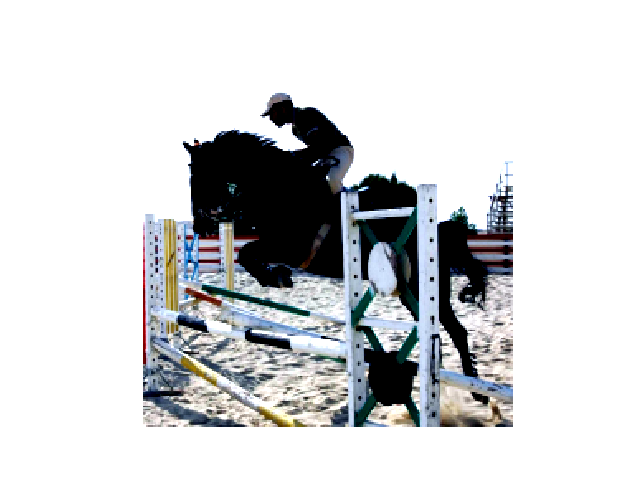

In [10]:
x, d = dataset_train[0]



y, f = dataset_val[1]

# myimshow(y)
# print(f)
z, e = dataset_test[8]

myimshow(x)



In [10]:
# x, d = dataset_test[0]
# print(d['annotation']['object'][0]['name'])



In [11]:
class VOCDataset(data.Dataset):
  
  def __init__(self, dataset, img_size = (224, 224)):
    super(VOCDataset, self).__init__()
    self.dataset = dataset
    self.img_size = img_size
  
  def collate_fn(self, batch):
    imgs, targets = list(zip(*batch))
    # Remove empty placeholder targets
    targets = [boxes for boxes in targets if boxes is not None]
    # Add sample index to targets
    for i, boxes in enumerate(targets):
        boxes[:, 0] = i
    targets = torch.cat(targets, 0)
    imgs = torch.stack([resize(img, img_size) for img in imgs])
    return imgs, targets

  def __getitem__(self, idx):
    x, d = self.dataset[idx]
    return x, d
  def __len__(self):
    return len(self.dataset)



In [12]:
trainset = VOCDataset(dataset_train)
valset = VOCDataset(dataset_val)
testset = VOCDataset(dataset_test)

# testset = testset[1]
print(len(trainset))
print(len(valset))
print(len(testset))



5717
11540
5823


In [13]:
object_to_idx = {'aeroplane': 0,'bicycle': 1,'bird': 2,'boat': 3,
              'bottle': 4,'bus': 5,'car': 6,'cat': 7,
              'chair': 8,'cow': 9,'diningtable': 10,'dog': 11,
              'horse': 12,'motorbike': 13,'person': 14,'pottedplant': 15,
              'sheep': 16,'sofa': 17,'train': 18,'tvmonitor': 19}


class_names = list(object_to_idx.keys())
print(class_names)



['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [14]:
# root = 'VOC2012'

# Y = download_url(DATASET_YEAR_DICT['2012']['url'], root, DATASET_YEAR_DICT['2012']['filename'], 
#                  DATASET_YEAR_DICT['2012']['md5'])

# object_to_idx = {'aeroplane': 0,'bicycle': 1,'bird': 2,'boat': 3,
#                   'bottle': 4,'bus': 5,'car': 6,'cat': 7,
#                   'chair': 8,'cow': 9,'diningtable': 10,'dog': 11,
#                   'horse': 12,'motorbike': 13,'person': 14,'pottedplant': 15,
#                   'sheep': 16,'sofa': 17,'train': 18,'tvmonitor': 19}
# boxes = [[object_to_idx[x['name']]] + [x['bndbox']['xmin'],x['bndbox']['ymin'],x['bndbox']['xmax'],x['bndbox']['ymax']] 
#          for x in d['annotation']['object']]

# print(boxes)

# boxes = np.array(boxes).astype(np.float)

# print(boxes)

# boxes = boxes.reshape(-1, 5)

# print(boxes)



In [15]:
# z = tarfile.open('VOC2012/VOCtrainval_11-May-2012.tar')
# z.extractall()



In [16]:
# class VOCDetection(data.Dataset):
    

In [17]:
classes = ['person' , 'bird', 'cat', 'cow',
           'dog', 'horse', 'sheep', 'aeroplane',
           'bicycle', 'boat', 'bus', 'car',
           'motorbike', 'train', 'bottle', 'chair',
           'diningtable', 'pottedplant', 'sofa', 'tvmonitor']



In [18]:
# parser = argparse.ArgumentParser()
# # parser.add_argument("--epochs", type=int, default=100, help="number of epochs")
# # parser.add_argument("--batch_size", type=int, default=8, help="size of each image batch")

# opt = parser.parse_args()

# funtion(batch_size=100, train_steps=1000)
# args = (100, 1000)
# function(*args)
Argument_Dict = {}
Argument_Dict['epochs'] = 100
Argument_Dict['batch_size'] = 8
Argument_Dict['model_def'] = 'config/yolov3-custom.cfg'
# Argument_Dict['pretrain_weights'] = True
Argument_Dict['pretrain_weights'] = 'checkpoints/yolov3_ckpt_87.pth' #train start
# Argument_Dict['pretrain_weights'] = 'checkpoints/yolov3_ckpt_59.pth' #test
#59 mAP is 0.55# 71 mAP 0.56
Argument_Dict['yolov3_weights'] = 'weights/yolov3.weights'
Argument_Dict['n_cpu'] = 8
Argument_Dict['gradient_accumulations'] = 2
Argument_Dict['evaluation_interval'] = 1
Argument_Dict['checkpoint_interval'] = 1
Argument_Dict['img_size'] = 224
Argument_Dict['conf_thres'] = 0.8 #object confidence threshold
Argument_Dict['nms_thres'] = 0.4 #iou thresshold for non-maximum suppression"

print(Argument_Dict)



{'epochs': 100, 'batch_size': 8, 'model_def': 'config/yolov3-custom.cfg', 'pretrain_weights': 'checkpoints/yolov3_ckpt_87.pth', 'yolov3_weights': 'weights/yolov3.weights', 'n_cpu': 8, 'gradient_accumulations': 2, 'evaluation_interval': 1, 'checkpoint_interval': 1, 'img_size': 224, 'conf_thres': 0.8, 'nms_thres': 0.4}


In [19]:
logger = Logger("logs")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

os.makedirs("output", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)



In [29]:
model = Darknet(Argument_Dict['model_def']).to(device)
model.apply(weights_init_normal)


Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [30]:

# If specified we start from checkpoint
if Argument_Dict['pretrain_weights']:
    if Argument_Dict['pretrain_weights'].endswith(".pth"):
        model.load_state_dict(torch.load(Argument_Dict['pretrain_weights']))
        print('load state dict')
    else:
        model.load_darknet_weights(Argument_Dict['yolov3_weights'])
        print('load darknet weights')
        
        

load state dict


In [31]:
dataloader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size= Argument_Dict['batch_size'],
    num_workers= Argument_Dict['n_cpu'],
    pin_memory= True,
    drop_last = True,
    shuffle = True,
    collate_fn= trainset.collate_fn,
)



In [32]:

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)


In [33]:
metrics = [
    "grid_size",
    "loss",
    "x",
    "y",
    "w",
    "h",
    "conf",
    "cls",
    "cls_acc",
    "recall50",
    "recall75",
    "precision",
    "conf_obj",
    "conf_noobj",
]
    
    

In [ ]:
for epoch in range(72,Argument_Dict['epochs']):
    model.train()
    start_time = time.time()
    for batch_i, (imgs, targets) in enumerate(dataloader):
        batches_done = len(dataloader) * epoch + batch_i

        imgs = Variable(imgs.to(device))
#         print(imgs.cpu().numpy().shape)
        targets = Variable(targets.to(device), requires_grad=False)

        loss, outputs = model(imgs, targets)
        loss.backward()

        if batches_done % Argument_Dict['gradient_accumulations']:
            # Accumulates gradient before each step
            optimizer.step()
            optimizer.zero_grad()

        # ----------------
        #   Log progress
        # ----------------

#         log_str = "\n---- [Epoch %d/%d, Batch %d/%d] ----\n" % (epoch, Argument_Dict['epochs'], batch_i, len(dataloader))

#         metric_table = [["Metrics", *[f"YOLO Layer {i}" for i in range(len(model.yolo_layers))]]]

#         # Log metrics at each YOLO layer
#         for i, metric in enumerate(metrics):
#             formats = {m: "%.6f" for m in metrics}
#             formats["grid_size"] = "%2d"
#             formats["cls_acc"] = "%.2f%%"
#             row_metrics = [formats[metric] % yolo.metrics.get(metric, 0) for yolo in model.yolo_layers]
#             metric_table += [[metric, *row_metrics]]

#             # Tensorboard logging
#             tensorboard_log = []
#             for j, yolo in enumerate(model.yolo_layers):
#                 for name, metric in yolo.metrics.items():
#                     if name != "grid_size":
#                         tensorboard_log += [(f"{name}_{j+1}", metric)]
#             tensorboard_log += [("loss", loss.item())]
#             logger.list_of_scalars_summary(tensorboard_log, batches_done)

#         log_str += AsciiTable(metric_table).table
#         log_str += f"\nTotal loss {loss.item()}"

#         # Determine approximate time left for epoch
#         epoch_batches_left = len(dataloader) - (batch_i + 1)
#         time_left = datetime.timedelta(seconds=epoch_batches_left * (time.time() - start_time) / (batch_i + 1))
#         log_str += f"\n---- ETA {time_left}"

#         print(log_str)

#         model.seen += imgs.size(0)

    if epoch % Argument_Dict['evaluation_interval'] == 0:
        log_str = "\n---- [Epoch %d/%d] ----\n" % (epoch, Argument_Dict['epochs'])
        log_str += f"\nTotal loss {loss.item()}"
        print(log_str)
        print("\n---- Evaluating Model ----")
        # Evaluate the model on the validation set
        precision, recall, AP, f1, ap_class = evaluate(
            model,
            dataset=valset, 
            iou_thres=0.5,
            conf_thres=0.5,
            nms_thres=0.5,
            img_size=Argument_Dict['img_size'],
            batch_size=Argument_Dict['batch_size'],
        )
        evaluation_metrics = [
            ("val_precision", precision.mean()),
            ("val_recall", recall.mean()),
            ("val_mAP", AP.mean()),
            ("val_f1", f1.mean()),
        ]
        
        logger.list_of_scalars_summary(evaluation_metrics, epoch)

        # Print class APs and mAP
        ap_table = [["Index", "Class name", "AP"]]
        for i, c in enumerate(ap_class):
            ap_table += [[c, class_names[c], "%.5f" % AP[i]]]
        print(AsciiTable(ap_table).table)
        print(f"---- mAP {AP.mean()}")

    if epoch % Argument_Dict['checkpoint_interval'] == 0:
        torch.save(model.state_dict(), f"checkpoints/yolov3_ckpt_%d.pth" % epoch)
#         Argument_Dict['pretrain_weights'] = 'checkpoints/yolov3_ckpt_%d.pth' % epoch
        
        


Detecting objects:   0%|          | 0/1443 [00:00<?, ?it/s]


---- [Epoch 72/100] ----

Total loss 0.2902399003505707

---- Evaluating Model ----



Detecting objects:   0%|          | 2/1443 [00:00<07:08,  3.36it/s]
Exception in thread Thread-8:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/datasets/home/64/164/shy003/.local/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/opt/conda/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

Computing AP: 100%|██████████| 20/20 [00:00<00:00, 170.37it/s]


+-------+-------------+---------+
| Index | Class name  | AP      |
+-------+-------------+---------+
| 0     | aeroplane   | 0.68066 |
| 1     | bicycle     | 0.54084 |
| 2     | bird        | 0.46612 |
| 3     | boat        | 0.36970 |
| 4     | bottle      | 0.36643 |
| 5     | bus         | 0.70610 |
| 6     | car         | 0.53565 |
| 7     | cat         | 0.65874 |
| 8     | chair       | 0.50668 |
| 9     | cow         | 0.47414 |
| 10    | diningtable | 0.54680 |
| 11    | dog         | 0.67138 |
| 12    | horse       | 0.54368 |
| 13    | motorbike   | 0.54650 |
| 14    | person      | 0.65991 |
| 15    | pottedplant | 0.40312 |
| 16    | sheep       | 0.44440 |
| 17    | sofa        | 0.49623 |
| 18    | train       | 0.57476 |
| 19    | tvmonitor   | 0.55329 |
+-------+-------------+---------+
---- mAP 0.5372560644291796


Detecting objects:   0%|          | 0/1443 [00:00<?, ?it/s]


---- [Epoch 73/100] ----

Total loss 0.3263692855834961

---- Evaluating Model ----


Computing AP: 100%|██████████| 20/20 [00:00<00:00, 144.46it/s]


+-------+-------------+---------+
| Index | Class name  | AP      |
+-------+-------------+---------+
| 0     | aeroplane   | 0.69442 |
| 1     | bicycle     | 0.55400 |
| 2     | bird        | 0.54144 |
| 3     | boat        | 0.39227 |
| 4     | bottle      | 0.39021 |
| 5     | bus         | 0.67994 |
| 6     | car         | 0.54846 |
| 7     | cat         | 0.72032 |
| 8     | chair       | 0.49494 |
| 9     | cow         | 0.51539 |
| 10    | diningtable | 0.56332 |
| 11    | dog         | 0.67067 |
| 12    | horse       | 0.60403 |
| 13    | motorbike   | 0.54806 |
| 14    | person      | 0.67847 |
| 15    | pottedplant | 0.43773 |
| 16    | sheep       | 0.49068 |
| 17    | sofa        | 0.54040 |
| 18    | train       | 0.66269 |
| 19    | tvmonitor   | 0.60936 |
+-------+-------------+---------+
---- mAP 0.5668400278045984


Detecting objects:   0%|          | 0/1443 [00:00<?, ?it/s]


---- [Epoch 74/100] ----

Total loss 0.2908242344856262

---- Evaluating Model ----


Computing AP: 100%|██████████| 20/20 [00:00<00:00, 125.76it/s]


+-------+-------------+---------+
| Index | Class name  | AP      |
+-------+-------------+---------+
| 0     | aeroplane   | 0.63482 |
| 1     | bicycle     | 0.53658 |
| 2     | bird        | 0.50288 |
| 3     | boat        | 0.35308 |
| 4     | bottle      | 0.37901 |
| 5     | bus         | 0.68726 |
| 6     | car         | 0.53998 |
| 7     | cat         | 0.71603 |
| 8     | chair       | 0.52567 |
| 9     | cow         | 0.43160 |
| 10    | diningtable | 0.54491 |
| 11    | dog         | 0.66273 |
| 12    | horse       | 0.58686 |
| 13    | motorbike   | 0.54934 |
| 14    | person      | 0.66059 |
| 15    | pottedplant | 0.42207 |
| 16    | sheep       | 0.47251 |
| 17    | sofa        | 0.48444 |
| 18    | train       | 0.70773 |
| 19    | tvmonitor   | 0.58279 |
+-------+-------------+---------+
---- mAP 0.5490445004759362


Detecting objects:   0%|          | 0/1443 [00:00<?, ?it/s]


---- [Epoch 75/100] ----

Total loss 0.3633894920349121

---- Evaluating Model ----


Computing AP: 100%|██████████| 20/20 [00:00<00:00, 168.44it/s]


+-------+-------------+---------+
| Index | Class name  | AP      |
+-------+-------------+---------+
| 0     | aeroplane   | 0.69118 |
| 1     | bicycle     | 0.56505 |
| 2     | bird        | 0.51444 |
| 3     | boat        | 0.42501 |
| 4     | bottle      | 0.37435 |
| 5     | bus         | 0.69018 |
| 6     | car         | 0.56217 |
| 7     | cat         | 0.67475 |
| 8     | chair       | 0.52237 |
| 9     | cow         | 0.50482 |
| 10    | diningtable | 0.57542 |
| 11    | dog         | 0.67842 |
| 12    | horse       | 0.61378 |
| 13    | motorbike   | 0.60737 |
| 14    | person      | 0.65430 |
| 15    | pottedplant | 0.44990 |
| 16    | sheep       | 0.46318 |
| 17    | sofa        | 0.58223 |
| 18    | train       | 0.65099 |
| 19    | tvmonitor   | 0.59935 |
+-------+-------------+---------+
---- mAP 0.5699630844237891


Detecting objects:   0%|          | 0/1443 [00:00<?, ?it/s]


---- [Epoch 76/100] ----

Total loss 0.28888973593711853

---- Evaluating Model ----


Computing AP: 100%|██████████| 20/20 [00:00<00:00, 187.12it/s]


+-------+-------------+---------+
| Index | Class name  | AP      |
+-------+-------------+---------+
| 0     | aeroplane   | 0.71523 |
| 1     | bicycle     | 0.58874 |
| 2     | bird        | 0.50743 |
| 3     | boat        | 0.36608 |
| 4     | bottle      | 0.35244 |
| 5     | bus         | 0.63687 |
| 6     | car         | 0.54864 |
| 7     | cat         | 0.71472 |
| 8     | chair       | 0.49154 |
| 9     | cow         | 0.44659 |
| 10    | diningtable | 0.54453 |
| 11    | dog         | 0.65584 |
| 12    | horse       | 0.62658 |
| 13    | motorbike   | 0.61719 |
| 14    | person      | 0.65417 |
| 15    | pottedplant | 0.38232 |
| 16    | sheep       | 0.40899 |
| 17    | sofa        | 0.45374 |
| 18    | train       | 0.68415 |
| 19    | tvmonitor   | 0.56721 |
+-------+-------------+---------+
---- mAP 0.5481495874818927


Detecting objects:   0%|          | 0/1443 [00:00<?, ?it/s]


---- [Epoch 77/100] ----

Total loss 0.27687621116638184

---- Evaluating Model ----


Computing AP: 100%|██████████| 20/20 [00:00<00:00, 161.21it/s]


+-------+-------------+---------+
| Index | Class name  | AP      |
+-------+-------------+---------+
| 0     | aeroplane   | 0.66498 |
| 1     | bicycle     | 0.52181 |
| 2     | bird        | 0.47289 |
| 3     | boat        | 0.34698 |
| 4     | bottle      | 0.36513 |
| 5     | bus         | 0.65810 |
| 6     | car         | 0.54473 |
| 7     | cat         | 0.64755 |
| 8     | chair       | 0.51125 |
| 9     | cow         | 0.45259 |
| 10    | diningtable | 0.52366 |
| 11    | dog         | 0.61484 |
| 12    | horse       | 0.60519 |
| 13    | motorbike   | 0.60723 |
| 14    | person      | 0.62233 |
| 15    | pottedplant | 0.42146 |
| 16    | sheep       | 0.40701 |
| 17    | sofa        | 0.55529 |
| 18    | train       | 0.66744 |
| 19    | tvmonitor   | 0.57882 |
+-------+-------------+---------+
---- mAP 0.539464339901919


Detecting objects:   0%|          | 0/1443 [00:00<?, ?it/s]


---- [Epoch 78/100] ----

Total loss 0.30316728353500366

---- Evaluating Model ----


Computing AP: 100%|██████████| 20/20 [00:00<00:00, 126.34it/s]


+-------+-------------+---------+
| Index | Class name  | AP      |
+-------+-------------+---------+
| 0     | aeroplane   | 0.69730 |
| 1     | bicycle     | 0.58517 |
| 2     | bird        | 0.53040 |
| 3     | boat        | 0.40279 |
| 4     | bottle      | 0.37678 |
| 5     | bus         | 0.66496 |
| 6     | car         | 0.57167 |
| 7     | cat         | 0.64668 |
| 8     | chair       | 0.53559 |
| 9     | cow         | 0.49041 |
| 10    | diningtable | 0.56176 |
| 11    | dog         | 0.63280 |
| 12    | horse       | 0.60474 |
| 13    | motorbike   | 0.61094 |
| 14    | person      | 0.65928 |
| 15    | pottedplant | 0.40325 |
| 16    | sheep       | 0.46260 |
| 17    | sofa        | 0.53897 |
| 18    | train       | 0.70447 |
| 19    | tvmonitor   | 0.62131 |
+-------+-------------+---------+
---- mAP 0.5650941609454037


Detecting objects:   0%|          | 0/1443 [00:00<?, ?it/s]


---- [Epoch 79/100] ----

Total loss 0.4872504472732544

---- Evaluating Model ----


Computing AP: 100%|██████████| 20/20 [00:00<00:00, 166.74it/s]


+-------+-------------+---------+
| Index | Class name  | AP      |
+-------+-------------+---------+
| 0     | aeroplane   | 0.67430 |
| 1     | bicycle     | 0.58773 |
| 2     | bird        | 0.51066 |
| 3     | boat        | 0.38274 |
| 4     | bottle      | 0.38351 |
| 5     | bus         | 0.70706 |
| 6     | car         | 0.57369 |
| 7     | cat         | 0.68210 |
| 8     | chair       | 0.53120 |
| 9     | cow         | 0.46110 |
| 10    | diningtable | 0.54896 |
| 11    | dog         | 0.70123 |
| 12    | horse       | 0.62907 |
| 13    | motorbike   | 0.66530 |
| 14    | person      | 0.66393 |
| 15    | pottedplant | 0.38523 |
| 16    | sheep       | 0.45915 |
| 17    | sofa        | 0.56564 |
| 18    | train       | 0.66823 |
| 19    | tvmonitor   | 0.57987 |
+-------+-------------+---------+
---- mAP 0.5680357015296296


Detecting objects:   0%|          | 0/1443 [00:00<?, ?it/s]


---- [Epoch 80/100] ----

Total loss 0.2816460430622101

---- Evaluating Model ----


Computing AP: 100%|██████████| 20/20 [00:00<00:00, 162.13it/s]


+-------+-------------+---------+
| Index | Class name  | AP      |
+-------+-------------+---------+
| 0     | aeroplane   | 0.69606 |
| 1     | bicycle     | 0.56384 |
| 2     | bird        | 0.51056 |
| 3     | boat        | 0.42624 |
| 4     | bottle      | 0.42062 |
| 5     | bus         | 0.70850 |
| 6     | car         | 0.57520 |
| 7     | cat         | 0.73030 |
| 8     | chair       | 0.54106 |
| 9     | cow         | 0.45359 |
| 10    | diningtable | 0.58679 |
| 11    | dog         | 0.68050 |
| 12    | horse       | 0.63004 |
| 13    | motorbike   | 0.61415 |
| 14    | person      | 0.65218 |
| 15    | pottedplant | 0.45019 |
| 16    | sheep       | 0.46792 |
| 17    | sofa        | 0.54089 |
| 18    | train       | 0.67534 |
| 19    | tvmonitor   | 0.60544 |
+-------+-------------+---------+
---- mAP 0.5764705016768435


Detecting objects:   0%|          | 0/1443 [00:00<?, ?it/s]


---- [Epoch 81/100] ----

Total loss 0.23242397606372833

---- Evaluating Model ----


Computing AP: 100%|██████████| 20/20 [00:00<00:00, 162.43it/s]


+-------+-------------+---------+
| Index | Class name  | AP      |
+-------+-------------+---------+
| 0     | aeroplane   | 0.72486 |
| 1     | bicycle     | 0.57469 |
| 2     | bird        | 0.56716 |
| 3     | boat        | 0.39320 |
| 4     | bottle      | 0.41016 |
| 5     | bus         | 0.72076 |
| 6     | car         | 0.58872 |
| 7     | cat         | 0.72057 |
| 8     | chair       | 0.54978 |
| 9     | cow         | 0.49973 |
| 10    | diningtable | 0.53345 |
| 11    | dog         | 0.70938 |
| 12    | horse       | 0.60674 |
| 13    | motorbike   | 0.65589 |
| 14    | person      | 0.67855 |
| 15    | pottedplant | 0.45204 |
| 16    | sheep       | 0.50539 |
| 17    | sofa        | 0.60031 |
| 18    | train       | 0.69568 |
| 19    | tvmonitor   | 0.64067 |
+-------+-------------+---------+
---- mAP 0.5913871837274743


Detecting objects:   0%|          | 0/1443 [00:00<?, ?it/s]


---- [Epoch 82/100] ----

Total loss 0.4487784504890442

---- Evaluating Model ----


Computing AP: 100%|██████████| 20/20 [00:00<00:00, 142.51it/s]


+-------+-------------+---------+
| Index | Class name  | AP      |
+-------+-------------+---------+
| 0     | aeroplane   | 0.64066 |
| 1     | bicycle     | 0.50945 |
| 2     | bird        | 0.46970 |
| 3     | boat        | 0.42596 |
| 4     | bottle      | 0.37319 |
| 5     | bus         | 0.65379 |
| 6     | car         | 0.54763 |
| 7     | cat         | 0.66549 |
| 8     | chair       | 0.50322 |
| 9     | cow         | 0.41051 |
| 10    | diningtable | 0.56397 |
| 11    | dog         | 0.60617 |
| 12    | horse       | 0.51349 |
| 13    | motorbike   | 0.53729 |
| 14    | person      | 0.62537 |
| 15    | pottedplant | 0.41077 |
| 16    | sheep       | 0.43241 |
| 17    | sofa        | 0.55470 |
| 18    | train       | 0.62172 |
| 19    | tvmonitor   | 0.57484 |
+-------+-------------+---------+
---- mAP 0.5320172344858898


Detecting objects:   0%|          | 0/1443 [00:00<?, ?it/s]


---- [Epoch 83/100] ----

Total loss 0.43346741795539856

---- Evaluating Model ----


Computing AP: 100%|██████████| 20/20 [00:00<00:00, 133.95it/s]


+-------+-------------+---------+
| Index | Class name  | AP      |
+-------+-------------+---------+
| 0     | aeroplane   | 0.69018 |
| 1     | bicycle     | 0.58615 |
| 2     | bird        | 0.56766 |
| 3     | boat        | 0.42247 |
| 4     | bottle      | 0.39702 |
| 5     | bus         | 0.70285 |
| 6     | car         | 0.56555 |
| 7     | cat         | 0.71577 |
| 8     | chair       | 0.54557 |
| 9     | cow         | 0.43188 |
| 10    | diningtable | 0.53137 |
| 11    | dog         | 0.65430 |
| 12    | horse       | 0.57518 |
| 13    | motorbike   | 0.60908 |
| 14    | person      | 0.67689 |
| 15    | pottedplant | 0.41890 |
| 16    | sheep       | 0.42429 |
| 17    | sofa        | 0.53370 |
| 18    | train       | 0.66017 |
| 19    | tvmonitor   | 0.59553 |
+-------+-------------+---------+
---- mAP 0.5652260168496728


Detecting objects:   0%|          | 0/1443 [00:00<?, ?it/s]


---- [Epoch 84/100] ----

Total loss 0.15209050476551056

---- Evaluating Model ----


Computing AP: 100%|██████████| 20/20 [00:00<00:00, 161.77it/s]


+-------+-------------+---------+
| Index | Class name  | AP      |
+-------+-------------+---------+
| 0     | aeroplane   | 0.71710 |
| 1     | bicycle     | 0.57671 |
| 2     | bird        | 0.59394 |
| 3     | boat        | 0.44294 |
| 4     | bottle      | 0.43286 |
| 5     | bus         | 0.66921 |
| 6     | car         | 0.57717 |
| 7     | cat         | 0.74669 |
| 8     | chair       | 0.55475 |
| 9     | cow         | 0.52902 |
| 10    | diningtable | 0.54751 |
| 11    | dog         | 0.71740 |
| 12    | horse       | 0.67264 |
| 13    | motorbike   | 0.65608 |
| 14    | person      | 0.67605 |
| 15    | pottedplant | 0.45065 |
| 16    | sheep       | 0.51197 |
| 17    | sofa        | 0.59579 |
| 18    | train       | 0.69032 |
| 19    | tvmonitor   | 0.63718 |
+-------+-------------+---------+
---- mAP 0.5998003038065187


Detecting objects:   0%|          | 0/1443 [00:00<?, ?it/s]


---- [Epoch 85/100] ----

Total loss 0.5276347398757935

---- Evaluating Model ----


Computing AP: 100%|██████████| 20/20 [00:00<00:00, 166.26it/s]


+-------+-------------+---------+
| Index | Class name  | AP      |
+-------+-------------+---------+
| 0     | aeroplane   | 0.72352 |
| 1     | bicycle     | 0.60590 |
| 2     | bird        | 0.57610 |
| 3     | boat        | 0.42878 |
| 4     | bottle      | 0.42581 |
| 5     | bus         | 0.73198 |
| 6     | car         | 0.61702 |
| 7     | cat         | 0.72517 |
| 8     | chair       | 0.57114 |
| 9     | cow         | 0.50866 |
| 10    | diningtable | 0.64721 |
| 11    | dog         | 0.63284 |
| 12    | horse       | 0.60896 |
| 13    | motorbike   | 0.68934 |
| 14    | person      | 0.69386 |
| 15    | pottedplant | 0.45782 |
| 16    | sheep       | 0.46333 |
| 17    | sofa        | 0.59723 |
| 18    | train       | 0.73057 |
| 19    | tvmonitor   | 0.63059 |
+-------+-------------+---------+
---- mAP 0.6032915586813095


Detecting objects:   0%|          | 0/1443 [00:00<?, ?it/s]


---- [Epoch 86/100] ----

Total loss 0.1311238706111908

---- Evaluating Model ----


Computing AP: 100%|██████████| 20/20 [00:00<00:00, 180.72it/s]


+-------+-------------+---------+
| Index | Class name  | AP      |
+-------+-------------+---------+
| 0     | aeroplane   | 0.75220 |
| 1     | bicycle     | 0.61737 |
| 2     | bird        | 0.59903 |
| 3     | boat        | 0.49552 |
| 4     | bottle      | 0.46769 |
| 5     | bus         | 0.74109 |
| 6     | car         | 0.61836 |
| 7     | cat         | 0.75533 |
| 8     | chair       | 0.55279 |
| 9     | cow         | 0.54973 |
| 10    | diningtable | 0.60424 |
| 11    | dog         | 0.69917 |
| 12    | horse       | 0.65056 |
| 13    | motorbike   | 0.67077 |
| 14    | person      | 0.69149 |
| 15    | pottedplant | 0.47884 |
| 16    | sheep       | 0.49932 |
| 17    | sofa        | 0.60519 |
| 18    | train       | 0.70223 |
| 19    | tvmonitor   | 0.63459 |
+-------+-------------+---------+
---- mAP 0.6192757121701322


Detecting objects:   0%|          | 0/1443 [00:00<?, ?it/s]


---- [Epoch 87/100] ----

Total loss 0.19454701244831085

---- Evaluating Model ----


Computing AP: 100%|██████████| 20/20 [00:00<00:00, 180.35it/s]


+-------+-------------+---------+
| Index | Class name  | AP      |
+-------+-------------+---------+
| 0     | aeroplane   | 0.76046 |
| 1     | bicycle     | 0.65284 |
| 2     | bird        | 0.61423 |
| 3     | boat        | 0.51658 |
| 4     | bottle      | 0.47360 |
| 5     | bus         | 0.76322 |
| 6     | car         | 0.64980 |
| 7     | cat         | 0.73400 |
| 8     | chair       | 0.58163 |
| 9     | cow         | 0.62180 |
| 10    | diningtable | 0.60585 |
| 11    | dog         | 0.67861 |
| 12    | horse       | 0.69510 |
| 13    | motorbike   | 0.70051 |
| 14    | person      | 0.69689 |
| 15    | pottedplant | 0.52733 |
| 16    | sheep       | 0.52809 |
| 17    | sofa        | 0.61886 |
| 18    | train       | 0.72016 |
| 19    | tvmonitor   | 0.62882 |
+-------+-------------+---------+
---- mAP 0.6384190417754859


Detecting objects:   0%|          | 0/1443 [00:00<?, ?it/s]


---- [Epoch 88/100] ----

Total loss 0.2090976983308792

---- Evaluating Model ----


Computing AP: 100%|██████████| 20/20 [00:00<00:00, 157.40it/s]


+-------+-------------+---------+
| Index | Class name  | AP      |
+-------+-------------+---------+
| 0     | aeroplane   | 0.74125 |
| 1     | bicycle     | 0.60389 |
| 2     | bird        | 0.51971 |
| 3     | boat        | 0.39506 |
| 4     | bottle      | 0.41445 |
| 5     | bus         | 0.71844 |
| 6     | car         | 0.62034 |
| 7     | cat         | 0.72459 |
| 8     | chair       | 0.57157 |
| 9     | cow         | 0.46112 |
| 10    | diningtable | 0.55550 |
| 11    | dog         | 0.62811 |
| 12    | horse       | 0.62093 |
| 13    | motorbike   | 0.62475 |
| 14    | person      | 0.66681 |
| 15    | pottedplant | 0.44776 |
| 16    | sheep       | 0.51181 |
| 17    | sofa        | 0.56739 |
| 18    | train       | 0.70244 |
| 19    | tvmonitor   | 0.63065 |
+-------+-------------+---------+
---- mAP 0.5863273474912145


Detecting objects:   0%|          | 0/1443 [00:00<?, ?it/s]


---- [Epoch 89/100] ----

Total loss 0.4235093295574188

---- Evaluating Model ----


Computing AP: 100%|██████████| 20/20 [00:00<00:00, 140.10it/s]


+-------+-------------+---------+
| Index | Class name  | AP      |
+-------+-------------+---------+
| 0     | aeroplane   | 0.70037 |
| 1     | bicycle     | 0.55618 |
| 2     | bird        | 0.54667 |
| 3     | boat        | 0.37914 |
| 4     | bottle      | 0.36404 |
| 5     | bus         | 0.67996 |
| 6     | car         | 0.56745 |
| 7     | cat         | 0.72397 |
| 8     | chair       | 0.51308 |
| 9     | cow         | 0.51232 |
| 10    | diningtable | 0.55127 |
| 11    | dog         | 0.64401 |
| 12    | horse       | 0.61049 |
| 13    | motorbike   | 0.58914 |
| 14    | person      | 0.61982 |
| 15    | pottedplant | 0.42016 |
| 16    | sheep       | 0.48862 |
| 17    | sofa        | 0.49352 |
| 18    | train       | 0.62029 |
| 19    | tvmonitor   | 0.59384 |
+-------+-------------+---------+
---- mAP 0.5587166530883676


In [23]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
os.makedirs("output", exist_ok=True)

model = Darknet(Argument_Dict['model_def'], img_size = 224).to(device)
model.load_state_dict(torch.load(Argument_Dict['pretrain_weights']))
model.eval()
# torch.save(model.state_dict(), f"weights/yolov3_custom_weights.pth")



cuda


Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [20]:
dataloader_test = DataLoader(
    dataset = testset,
    batch_size= 1,
#     num_workers= Argument_Dict['n_cpu'],
    drop_last = True,
    shuffle=False,
)



loader_length = len(dataloader_test)

print(loader_length)

mini_batch = []
mini_label = []
for batch_i, (local_batch, local_label) in enumerate(dataloader_test):
    mini_batch.append(local_batch)
    mini_label.append(local_label)
    
    


5823


KeyboardInterrupt: 

In [21]:
print(mini_batch[0].shape)

torch.Size([1, 3, 224, 224])


In [28]:
Argument_Dict['plot'] = 14
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# input_imgs, y = valset[1]
input_imgs = mini_batch[Argument_Dict['plot']]
input_imgs = Variable(input_imgs.type(Tensor))

with torch.no_grad():
    detections = model(input_imgs)
    detections = non_max_suppression(detections, Argument_Dict['conf_thres'], Argument_Dict['nms_thres'])

cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)] 
detections_ori = detections[0]
print(detections)
test_img = input_imgs.cpu().resize_(3, 224, 224)



[tensor([[110.8630,  92.3990, 118.0972, 125.9017,   1.0000,   1.0000,  14.0000],
        [101.5174,  90.2501, 109.5568, 130.9398,   1.0000,   0.9998,  14.0000],
        [114.1812,  91.8254, 120.7529, 124.0746,   0.9992,   0.9999,  14.0000],
        [114.3018,  85.9679, 197.9817, 163.3375,   0.8120,   0.9877,   6.0000]])]


<IPython.core.display.Javascript object>


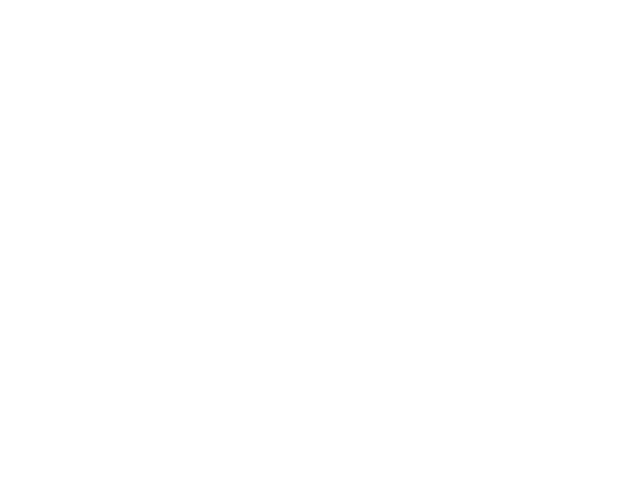

<IPython.core.display.Javascript object>


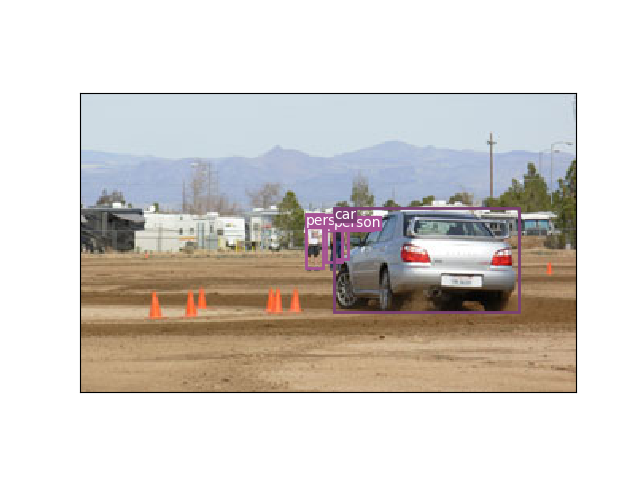

	+ Label: person, Conf: 0.99998
tensor(10.0762)
tensor(28.1183)
tensor(154.4163)
tensor(77.5492)
	+ Label: person, Conf: 0.99979
tensor(11.1977)
tensor(34.1503)
tensor(141.3993)
tensor(75.7456)
	+ Label: person, Conf: 0.99989
tensor(9.1534)
tensor(27.0663)
tensor(159.0381)
tensor(77.0678)
	+ Label: car, Conf: 0.98767
tensor(116.5542)
tensor(64.9352)
tensor(159.2061)
tensor(72.1516)


In [29]:
unique_labels = detections[0][:, -1].cpu().unique()
n_cls_preds = len(unique_labels)
bbox_colors = random.sample(colors, n_cls_preds)

img, lll = dataset_origin[Argument_Dict['plot']]
test_img_size = [np.size(img)[0], np.size(img)[1]]
im = np.array(img)
plt.figure()
fig, ax = plt.subplots(1)
ax.imshow(im)
original_shape = test_img_size
current_dim = 224
orig_w, orig_h = original_shape

for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections_ori:
    if cls_conf > Argument_Dict['nms_thres']:
        print("\t+ Label: %s, Conf: %.5f" % (class_names[int(cls_pred)], cls_conf.item()))
        x1 = x1 * orig_w / current_dim
        y1 = y1 * orig_h / current_dim
        x2 = x2 * orig_w / current_dim
        y2 = y2 * orig_h / current_dim
        box_w = x2 - x1
        box_h = y2 - y1
        print(box_w)
        print(box_h)
        print(x1)
        print(y1)

        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]

        # Create a Rectangle patch
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")


        # Add the bbox to the plot
        ax.add_patch(bbox)

        # Add label
        plt.text(
            x1,
            y1,
            s=class_names[int(cls_pred)],
            color="white",
            verticalalignment="top",
            bbox={"color": color, "pad": 0},
        )
plt.gca().xaxis.set_major_locator(NullLocator())
plt.gca().yaxis.set_major_locator(NullLocator())  
# plt.gca().invert_yaxis()
plt.show()  



In [34]:
object_to_idx


{'aeroplane': 0,
 'bicycle': 1,
 'bird': 2,
 'boat': 3,
 'bottle': 4,
 'bus': 5,
 'car': 6,
 'cat': 7,
 'chair': 8,
 'cow': 9,
 'diningtable': 10,
 'dog': 11,
 'horse': 12,
 'motorbike': 13,
 'person': 14,
 'pottedplant': 15,
 'sheep': 16,
 'sofa': 17,
 'train': 18,
 'tvmonitor': 19}

In [37]:
checkpoint = torch.load(Argument_Dict['pretrain_weights'])

for p in checkpoint:
    print(p)

# model.load_state_dict(torch.load(Argument_Dict['pretrain_weights']))



module_list.0.conv_0.weight
module_list.0.batch_norm_0.weight
module_list.0.batch_norm_0.bias
module_list.0.batch_norm_0.running_mean
module_list.0.batch_norm_0.running_var
module_list.0.batch_norm_0.num_batches_tracked
module_list.1.conv_1.weight
module_list.1.batch_norm_1.weight
module_list.1.batch_norm_1.bias
module_list.1.batch_norm_1.running_mean
module_list.1.batch_norm_1.running_var
module_list.1.batch_norm_1.num_batches_tracked
module_list.2.conv_2.weight
module_list.2.batch_norm_2.weight
module_list.2.batch_norm_2.bias
module_list.2.batch_norm_2.running_mean
module_list.2.batch_norm_2.running_var
module_list.2.batch_norm_2.num_batches_tracked
module_list.3.conv_3.weight
module_list.3.batch_norm_3.weight
module_list.3.batch_norm_3.bias
module_list.3.batch_norm_3.running_mean
module_list.3.batch_norm_3.running_var
module_list.3.batch_norm_3.num_batches_tracked
module_list.5.conv_5.weight
module_list.5.batch_norm_5.weight
module_list.5.batch_norm_5.bias
module_list.5.batch_norm_5

In [18]:

# img, lll = dataset_origin[Argument_Dict['plot']]

# test_img_size = [np.size(img)[0], np.size(img)[1]]

# im = np.array(img)
# plt.figure()
# fig, ax = plt.subplots(1)
# ax.imshow(im)


# pad_x = max(orig_h - orig_w, 0) * (current_dim / max(original_shape))
# pad_y = max(orig_w - orig_h, 0) * (current_dim / max(original_shape))
# print(pad_x)
# print(pad_y)
# unpad_h = current_dim - pad_y
# unpad_w = current_dim - pad_x
# print(unpad_h)
# print(unpad_w)
# print(pad_x // 2)
# detectionss = detections_ori
# print(detections_ori)

# detectionssx1 = ((detectionss[:, 0] + pad_x // 2) / unpad_w) * orig_w
# detectionssy1 = ((detectionss[:, 1] + pad_y // 2) / unpad_h) * orig_h
# detectionssx2 = ((detectionss[:, 2] - pad_x // 2) / unpad_w) * orig_w
# detectionssy2 = ((detectionss[:, 3] - pad_y // 2) / unpad_h) * orig_h
# print(detectionssx1)
# print(detectionssy1)
# print(detectionssx2)
# print(detectionssy2)

